In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import dowhy
import networkx as nx
from dowhy import CausalModel

warnings.filterwarnings('ignore')

/Users/alvarocorralescano/opt/anaconda3/envs/idealista/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data

In [2]:
df_daily = pd.read_csv('Processed data/valid_data_fe.csv')
df_daily.head()

,LCLid,Date,kwh_hh,treat,is_weekend,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,...,temp,feelslike,precip,cloudcover,Acorn,Acorn_enc,got_high_signal,got_low_signal,high_signal_intensity,low_signal_intensity
0,MAC000006,2012-01-30,2.162,0,0,1,0,0,0,0,...,3.0,1.7,0.299,70.1,ACORN-Q,16.0,0,0,0,0
1,MAC000006,2012-01-31,3.906,0,0,0,0,0,0,1,...,1.7,-0.8,0.298,65.0,ACORN-Q,16.0,0,0,0,0
2,MAC000006,2012-02-01,3.587,0,0,0,0,0,0,0,...,1.3,-3.6,0.000,35.0,ACORN-Q,16.0,0,0,0,0
3,MAC000006,2012-02-02,3.416,0,0,0,0,0,1,0,...,-0.2,-4.8,0.000,10.4,ACORN-Q,16.0,0,0,0,0
4,MAC000006,2012-02-03,3.739,0,0,0,0,0,0,0,...,-0.2,-3.1,0.000,28.5,ACORN-Q,16.0,0,0,0,0


In [3]:
df_daily.columns

Index(['LCLid', 'Date', 'kwh_hh', 'treat', 'is_weekend', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'year_2013', 'treat_2013', 'temp',
       'feelslike', 'precip', 'cloudcover', 'Acorn', 'Acorn_enc',
       'got_high_signal', 'got_low_signal', 'high_signal_intensity',
       'low_signal_intensity'],
      dtype='object')

## Treatment effects

In [4]:
# Initialize directed graph
G = nx.DiGraph()

# List of causes
causes = ['day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'temp',
       'feelslike', 'precip', 'cloudcover', 'Acorn_enc'] 
       
# Add edges from each cause to 'kwh_hh'
for cause in causes:
    G.add_edge(cause, 'kwh_hh')

# Add the path from treat to treat_2013 to kwh_hh 
# Actual treatment variable is treat_2013, but treated households were already different in 2012
G.add_edges_from([
    ('treat', 'treat_2013'),
    ('treat_2013', 'kwh_hh'),
])

G.add_edges_from([
    ('treat', 'kwh_hh'),
])

# We have reasons to believe that treatment assignment may have depended on accorn status
G.add_edges_from([
    ('Acorn_enc', 'treat')
])

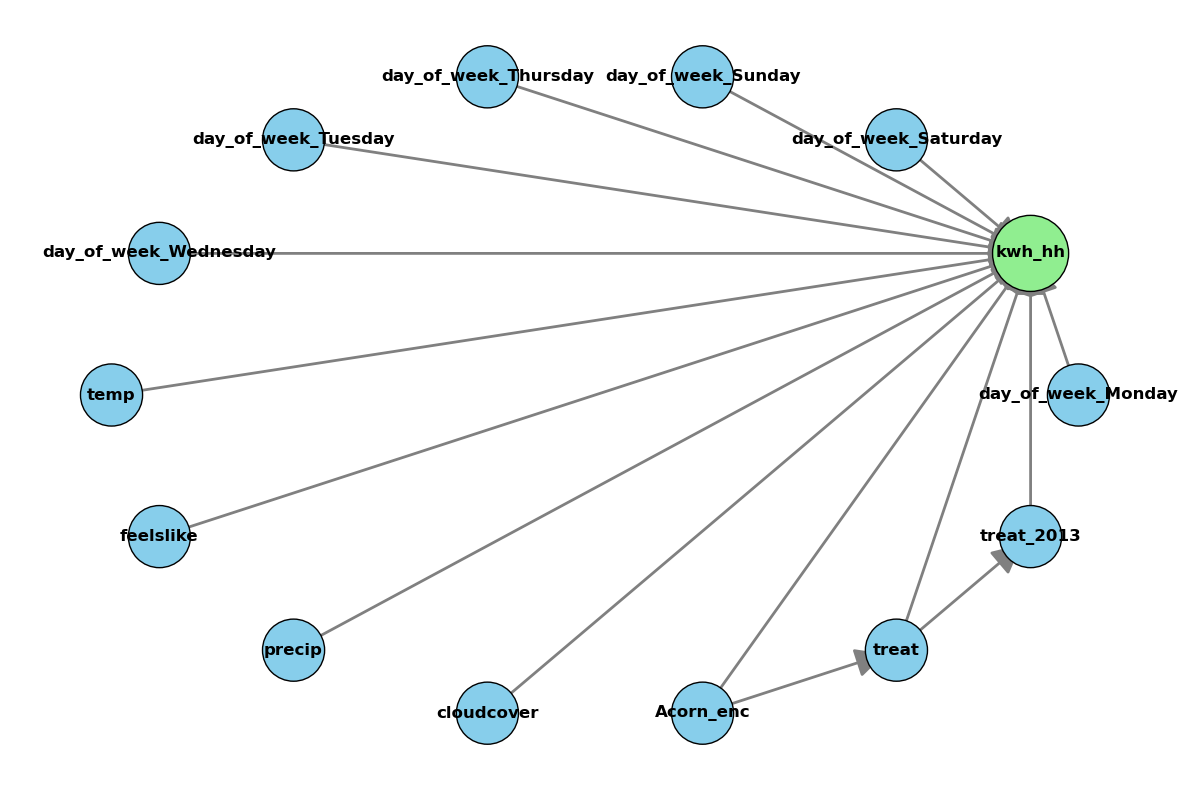

In [5]:
# Draw the graph
plt.figure(figsize=(12, 8))

# Use shell layout for a more circular, cleaner arrangement
pos = nx.circular_layout(G) 

# Draw nodes with a color gradient and different sizes based on their degree
node_sizes = [3000 if node == 'kwh_hh' else 2000 for node in G.nodes()]
node_colors = ['lightgreen' if node == 'kwh_hh' else 'skyblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')

# Draw edges with arrows and custom width/color
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=45, edge_color='gray', width=2)

# Add labels to the nodes
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', font_weight='bold')

# Remove axis for a cleaner look
plt.axis('off')

# Show the graph
plt.tight_layout()
plt.savefig('Images/whole_network.png')
plt.show()

In [6]:
model = CausalModel(
   data=df_daily, 
   treatment=['treat_2013'],  # Actual treatment, whose effect we want to quantify
   common_causes = ['treat'], # Treated households were already different in 2012
   effect_modifiers=causes,
   outcome="kwh_hh",
   graph="\n".join(nx.generate_gml(G))
)

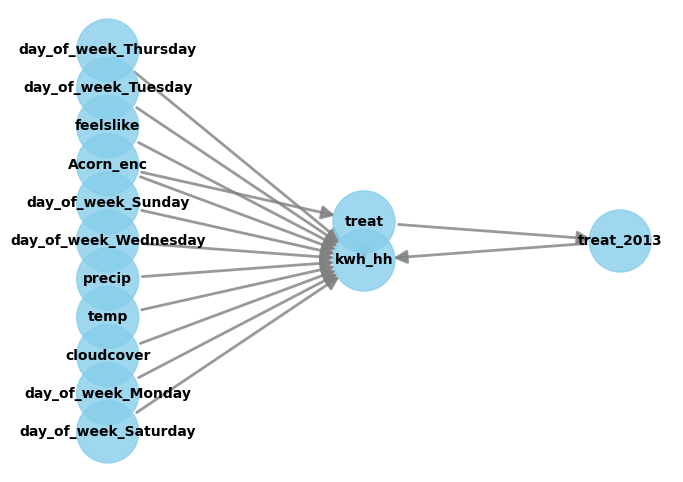

In [7]:
model.view_model()

In [8]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                       
────────────(E[kwh_hh|treat])
d[treat₂₀₁₃]                 
Estimand assumption 1, Unconfoundedness: If U→{treat_2013} and U→kwh_hh then P(kwh_hh|treat_2013,treat,U) = P(kwh_hh|treat_2013,treat)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [9]:
linear_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
# print('Causal estimate value:', linear_estimate.value)
print(linear_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                       
────────────(E[kwh_hh|treat])
d[treat₂₀₁₃]                 
Estimand assumption 1, Unconfoundedness: If U→{treat_2013} and U→kwh_hh then P(kwh_hh|treat_2013,treat,U) = P(kwh_hh|treat_2013,treat)

## Realized estimand
b: kwh_hh~treat_2013+treat+treat_2013*day_of_week_Monday+treat_2013*day_of_week_Saturday+treat_2013*cloudcover+treat_2013*temp+treat_2013*precip+treat_2013*day_of_week_Wednesday+treat_2013*day_of_week_Sunday+treat_2013*feelslike+treat_2013*day_of_week_Tuesday+treat_2013*day_of_week_Thursday
Target units: 

## Estimate
Mean value: -0.24267627746639242
### Conditional Estimates
__categorical__day_of_week_Monday  __categorical__day_of_week_Saturday  __categorical__cloudcover  __categorical__temp  __categorical__precip  __categorical__day_of_week_Wednesday  __categorical__day_of_week_Sunday  _

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV   

dml_estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.DML",
                                    control_value = 0,
                                    treatment_value = 1,
                                    #  target_units = lambda df_daily: df_daily["Acorn_enc"]>=15,  # condition used for CATE
                                    confidence_intervals=False,
                                    method_params={"init_params":{'model_y': GradientBoostingRegressor(random_state=42),
                                                                'model_t': GradientBoostingRegressor(random_state=42),
                                                                'featurizer':PolynomialFeatures(degree=2, include_bias=False),
                                                                'model_final': ElasticNetCV(random_state=42),
                                                                'random_state': 42},
                                                    "fit_params":{}}
                                    )
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                       
────────────(E[kwh_hh|treat])
d[treat₂₀₁₃]                 
Estimand assumption 1, Unconfoundedness: If U→{treat_2013} and U→kwh_hh then P(kwh_hh|treat_2013,treat,U) = P(kwh_hh|treat_2013,treat)

## Realized estimand
b: kwh_hh~treat_2013+treat | day_of_week_Monday,day_of_week_Saturday,cloudcover,temp,precip,day_of_week_Wednesday,day_of_week_Sunday,feelslike,day_of_week_Tuesday,day_of_week_Thursday
Target units: Data subset defined by a function

## Estimate
Mean value: -0.2565439304497093
Effect estimates: [[-0.30349932]
 [-0.26094465]
 [-0.07565851]
 ...
 [-0.10030712]
 [-0.23284045]
 [-0.29149772]]



A very interesting feature of DoWhy is the ability to calculate treatment effects for certain target units (i.e. some individuals with some characteristics of interest). In the snippet above, this line is commented out. If we include it in the estimation process, the result would be the average treatment effect for individuals with an Acorn classification of 12 or above which, in our encoding system, corresponds to the 33% most deprived segments. For these households, the treatment effect was -0.2719, about 15% more than the average. This implies that the LCL project had a larger impact on less affluent households (although we can't say why).

In [36]:
dml_estimate.value

#### Refute estimate

In [33]:
# Adding a random common cause variable
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause", show_progress_bar=True)
print(res_random)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [69]:
# Replacing treatment with a random (placebo) variable
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", show_progress_bar=True, placebo_type="permute")
print(res_placebo)

In [70]:
# Removing random subset of the data
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", show_progress_bar=True, subset_fraction=0.9)
print(res_subset)

KeyboardInterrupt: 

### Alternative graph model - separate models for each intensity

In [254]:
# Initialize directed graph
G_alt = nx.DiGraph()

# List of causes
causes = ['day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'temp',
       'feelslike', 'precip', 'cloudcover', 'Acorn_enc'] 
       
# Add edges from each cause to 'kwh_hh'
for cause in causes:
    G_alt.add_edge(cause, 'kwh_hh')

# Add the paths described in the question
# Path 1: treat to treatment in 2013 to getting high signal to consumption
G_alt.add_edges_from([
    ('treat', 'treat_2013'),
    ('treat_2013', 'got_high_signal'),
    ('got_high_signal', 'kwh_hh')
])

# Path 2: treat to treatment in 2013 to getting low signal to consumption
G_alt.add_edges_from([
    ('treat', 'treat_2013'),
    ('treat_2013', 'got_low_signal'),
    ('got_low_signal', 'kwh_hh')
])

# Even though our treatment here will be the type of signal received (if any), 
# knowing to be part of treatment group may have an impact on energy consumption
G_alt.add_edges_from([
    ('treat', 'treat_2013'),
    ('treat_2013', 'kwh_hh'),
])

# Again, treatment group was already different before 2013
G_alt.add_edges_from([
    ('treat', 'kwh_hh'),
])

# Again, it doesn't look like treatment was fully randomised
G_alt.add_edges_from([
    ('Acorn_enc', 'treat')
])

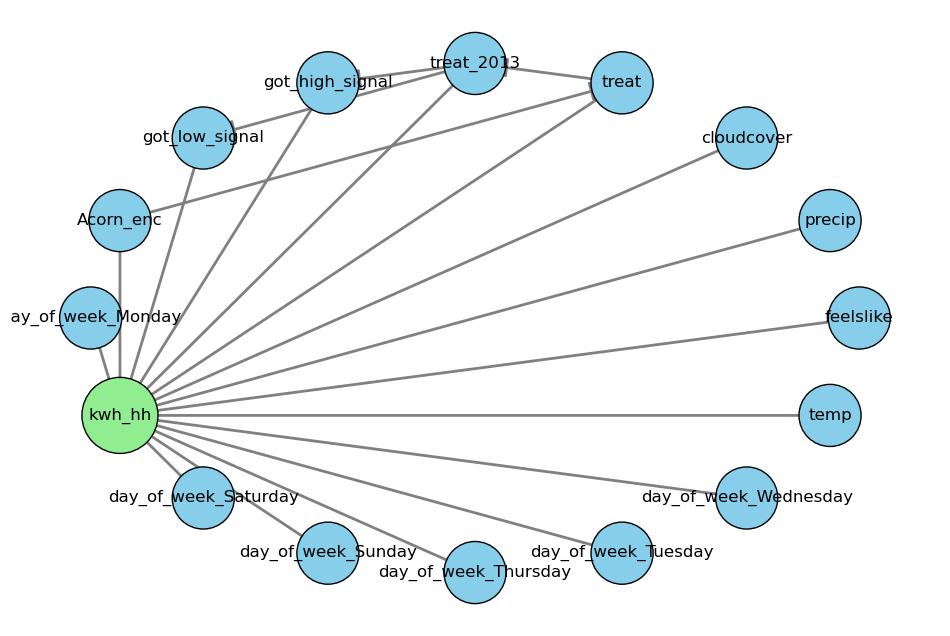

In [255]:
# Draw the graph
plt.figure(figsize=(12, 8))

# Use shell layout for a more circular, cleaner arrangement
pos = nx.circular_layout(G_alt) 

# Draw nodes with a color gradient and different sizes based on their degree
node_sizes = [3000 if node == 'kwh_hh' else 2000 for node in G_alt.nodes()]
node_colors = ['lightgreen' if node == 'kwh_hh' else 'skyblue' for node in G_alt.nodes()]
nx.draw_networkx_nodes(G_alt, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')

# Draw edges with arrows and custom width/color
nx.draw_networkx_edges(G_alt, pos, arrowstyle='-|>', arrowsize=45, edge_color='gray', width=2)

# Add labels to the nodes
nx.draw_networkx_labels(G_alt, pos, font_size=12, font_color='black', font_weight='bold')

# Remove axis for a cleaner look
plt.axis('off')

# Show the graph
plt.tight_layout()
plt.savefig('Images/whole_network.png')
plt.show()



In [259]:
# Low intensity model
# Define model
model_low = CausalModel(
   data=df_daily, # some pandas dataframe
   treatment=['got_low_signal'],
   common_causes = ['treat'],
   effect_modifiers=causes.append('Acorn_enc'),
   outcome="kwh_hh",
   graph="\n".join(nx.generate_gml(G_alt))
)

# Identify estimand
identified_estimand_low = model_low.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand_low)

# Quantify causal estimate
causal_estimate_low = model_low.estimate_effect(
    identified_estimand_low,
    method_name="backdoor.linear_regression",
    # confidence_intervals = True
    )
print('Causal estimate value:', round(causal_estimate_low.value, 4))
# print('Causal estimate CI:', causal_estimate_low.get_confidence_intervals())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                              
─────────────────(E[kwh_hh|treat_2013])
d[got_low_signal]                      
Estimand assumption 1, Unconfoundedness: If U→{got_low_signal} and U→kwh_hh then P(kwh_hh|got_low_signal,treat_2013,U) = P(kwh_hh|got_low_signal,treat_2013)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Causal estimate value: 0.2651


In [258]:
# High intensity model
# Define model
model_high = CausalModel(
   data=df_daily, # some pandas dataframe
   treatment=['got_high_signal'],
   common_causes = ['treat'],
   effect_modifiers=causes.append('Acorn_enc'),
   outcome="kwh_hh",
   graph="\n".join(nx.generate_gml(G_alt))
)

# Identify estimand
identified_estimand_high = model_high.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand_high)

# Quantify causal estimate
causal_estimate_high = model_high.estimate_effect(
    identified_estimand_high,
    method_name="backdoor.linear_regression",
    # confidence_intervals = True
    )
print('Causal estimate value:', round(causal_estimate_high.value, 4))
# print('Causal estimate value:', causal_estimate_high.get_confidence_intervals())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                               
──────────────────(E[kwh_hh|treat_2013])
d[got_high_signal]                      
Estimand assumption 1, Unconfoundedness: If U→{got_high_signal} and U→kwh_hh then P(kwh_hh|got_high_signal,treat_2013,U) = P(kwh_hh|got_high_signal,treat_2013)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Causal estimate value: -0.2541


In [106]:
# causal_estimate_high.get_confidence_intervals()

In [125]:
causal_estimate_high.conditional_estimates.index.names

FrozenList(['__categorical__day_of_week_Sunday', '__categorical__is_weekend', '__categorical__day_of_week_Saturday', '__categorical__feelslike', '__categorical__temp', '__categorical__got_low_signal', '__categorical__day_of_week_Monday', '__categorical__day_of_week_Tuesday', '__categorical__day_of_week_Thursday', '__categorical__day_of_week_Wednesday', '__categorical__cloudcover', '__categorical__precip'])

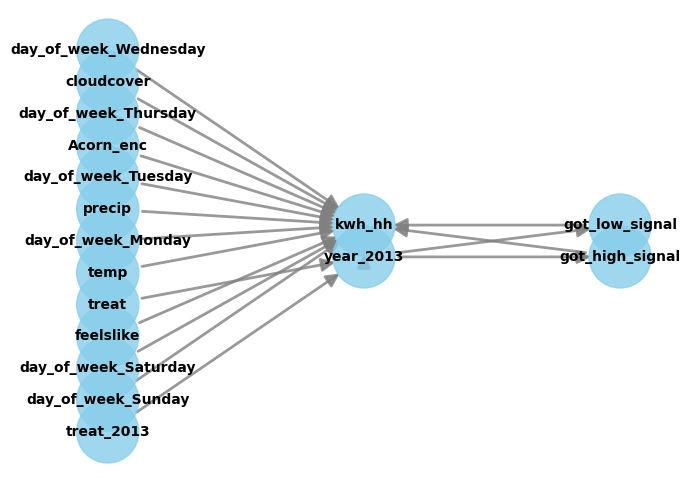

In [212]:
model_high.view_model()